# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project rubric.

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
from scipy.stats import iqr

import seaborn as sns


df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Adjusting the article id to be string instead of float
df.article_id = df.article_id.astype(str)

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [89]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>  

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.  

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [90]:
# Resume dataset with number of articles by user
df_count_articles = df[['article_id', 'email']].groupby('email').agg(n_article=('article_id', 'count')).sort_values('n_article')

df_count_articles

,n_article
email,
6755c5d49a97e785583f65a92f72bc09459905a9,1
3fbe4978a20ee5ddc07648f2762b808ea18cedd1,1
9c4b5dda1282c94128a7dc778951a313cce8055b,1
3fac88958dc7903b380743597f44a79cf76ea128,1
efdb4c363358224cd99d45053e2dbddf659e25ce,1
...,...
8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170


To see better the distribuition of interactions

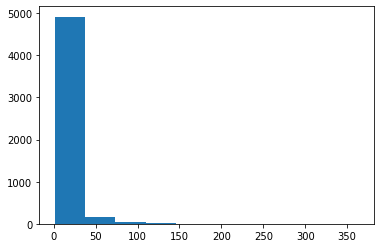

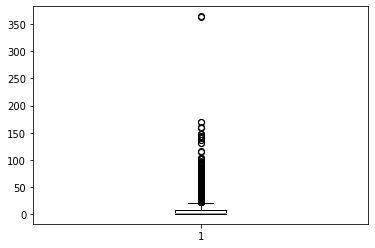

,count,mean,std,min,25%,50%,75%,max
n_article,5148.0,8.930847,16.802267,1.0,1.0,3.0,9.0,364.0


In [91]:
plt.hist(df_count_articles)
plt.show()

plt.boxplot(df_count_articles)
plt.show()

df_count_articles.describe().T

By statistics, it is seen that majority of users interacts with at least 3 articles (median).  

Some user are outliers in the dataset, with more than normal.

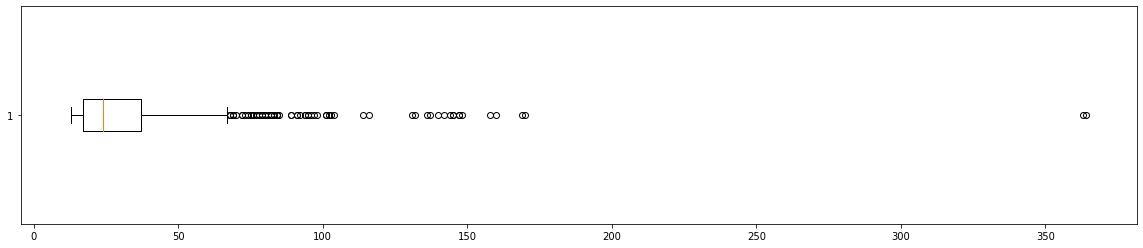

,count,mean,std,min,25%,50%,75%,max
n_article,934.0,32.801927,28.624493,13.0,17.0,24.0,37.0,364.0


In [92]:
# Interquartile range
iqr_value = iqr(df_count_articles)



# Filtering the dataset and see the boxplot
plt.figure(figsize=(20,4))
plt.boxplot(df_count_articles[df_count_articles.n_article > 1.5*iqr_value], vert=False )
plt.show()

# Describe it
df_count_articles[df_count_articles.n_article > 1.5*iqr_value].describe().T


Outliers begins in 10 articles and goes until 364, with two users in the region of values

Observing these users closely:


In [93]:
# Get the index of two users with bigger number of articles 
inds = df_count_articles.index[-2:]

df_2 = df.loc[df.email.isin(inds)]

# Number of unique articles
unique_articles = df.article_id.nunique()
# Number of articles that two users seen toghter
unique_articles_2 = df_2.article_id.nunique()
# Porportion
print(f'Together, the two users saw {(unique_articles_2/unique_articles)*100:.2f}% of total articles')

Together, the two users saw 19.05% of total articles


Only two users saw almost 20% of articles in dataset.     
Maybe the both will show a great simmilarity.

Summarize the staticts of interactions

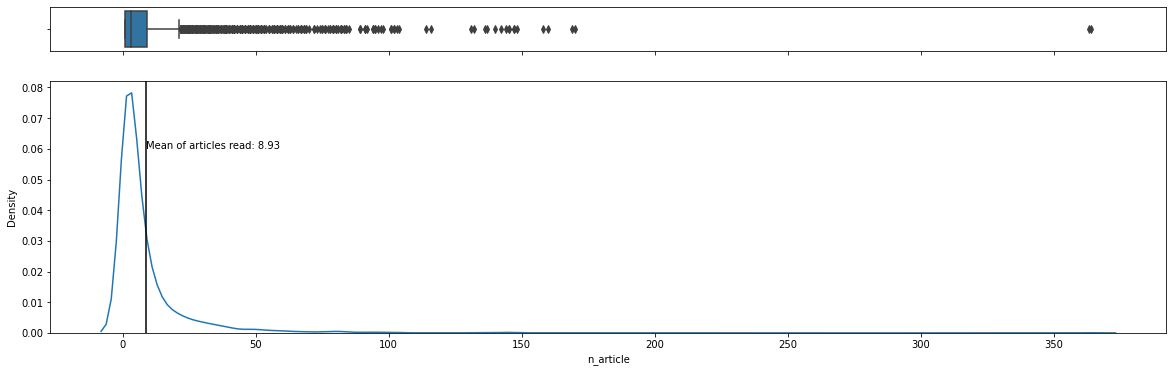

In [94]:
df_count_articles

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(20,6), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(data=df_count_articles, x='n_article', ax=ax_box)
sns.kdeplot(data=df_count_articles, x='n_article', ax=ax_hist)

mean_ = df_count_articles.n_article.mean()
ax_hist.axvline(mean_, color='black')
ax_hist.annotate(f'Mean of articles read: {mean_:.2f}', (mean_, 0.06) )

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()


In [95]:
# Fill in the median and maximum number of user_article interactios below

median_val = df_count_articles.n_article.median() 
max_views_by_user = df_count_articles.n_article.max() 

print(f"50% of individuals interact with {median_val:.0f} number of articles or fewer.")
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')


50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [96]:
# Find and explore duplicate articles
df_content.article_id.duplicated().sum()

5

In [97]:
df_content.loc[df_content.article_id.duplicated(keep=False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


There is 5 articles duplicated in the dataset

In [98]:
# Remove any rows that have the same article_id - only keep the first
df_content_new = df_content.drop_duplicates(subset=['article_id'], keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [99]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content_new.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique(dropna=True) # The number of unique users
user_article_interactions = df[['article_id', 'email']].shape[0] # The number of user-article interactions

print(f'a: {unique_articles} unique articles that have at least one interaction' )
print(f'b: {total_articles} unique articles on the IBM platform')
print(f'c: {unique_users} unique users')
print(f'd: {user_article_interactions} user-article interactions')

a: 714 unique articles that have at least one interaction
b: 1051 unique articles on the IBM platform
c: 5148 unique users
d: 45993 user-article interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [100]:
most_viewed_article_id = df.article_id.value_counts().keys()[0] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().values[0] # The most viewed article in the dataset was viewed how many times?
most_viewed_article_title = df.loc[df.article_id == most_viewed_article_id].title.unique()[0]

print(f'The most viewed article was with id {most_viewed_article_id} and title \"{most_viewed_article_title}\".\nIt was viewed {max_views:.0f} times')

The most viewed article was with id 1429.0 and title "use deep learning for image classification".
It was viewed 937 times


In [101]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df.loc[:, 'email']: 
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df = df.assign(user_id=email_encoded)

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [102]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

most_viewed_article_id = str(most_viewed_article_id)

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [103]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Dataset with number of interactions
    df_interaction = df.groupby(['article_id', 'title'], as_index=False). \
        agg(count=('article_id', 'count')). \
        sort_values('count', ascending=False)

    top_articles = list(df_interaction.iloc[:n]['title'])

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    '''
    # Dataset with number of interactions
    df_interaction = df.groupby(['article_id', 'title'], as_index=False). \
        agg(count=('article_id', 'count')). \
        sort_values('count', ascending=False)

    top_articles = list(df_interaction.iloc[:n]['article_id'])
 
    return top_articles # Return the top article ids

In [104]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [105]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [106]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # First, create a new column with 1's
    user_item = df[['user_id', 'article_id']].assign(interact=int(1))
    # Then, pivot the table, using max aggregation
    user_item = user_item.pivot_table(index='user_id', columns='article_id', 
        values='interact', aggfunc='max')
    # Finally, fill empty values with 0
    user_item = user_item.fillna(0)

    return user_item 

user_item = create_user_item_matrix(df)

In [107]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [108]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # User matrix for user_id input
    user_mat = user_item.loc[user_id]
    
    sim_arr = []
    # Iterate for each user in dataframe
    for user, user_row in user_item.iterrows():
        sim_dict = {}
        # Calculate similarity
        sim = np.dot(user_mat, user_row)
        # Create a dict to hold the result
        sim_dict['user'] = user 
        sim_dict['sim'] = sim
        # Creat a list of dicts
        sim_arr.append(sim_dict)
    
    # Create a dataframe to manipulate
    sim_df = pd.DataFrame(sim_arr)

    # sort by similarity
    sim_df = sim_df.sort_values('sim', ascending=False)

    # create list of just the ids
    most_similar_users = sim_df.user.to_numpy()

    # remove the own user's id
    most_similar_users = np.delete(most_similar_users, 
        np.where(most_similar_users == user_id))
       
    return most_similar_users         

In [109]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459 3870  131 4201   46 5041]
The 5 most similar users to user 3933 are: [   1   23 3782  203 4459]
The 3 most similar users to user 46 are: [4201 3782   23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [110]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    # Resume dataset
    df_articles = df[['article_id', 'title']].drop_duplicates()
    # Location the article
    article_names = []
    for id in article_ids:
        title_ = df_articles.loc[df_articles.article_id == id].title.iloc[0]
        article_names.append(title_)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # The matrix of selected user
    user_mat = user_item.loc[user_id]
    article_ids = list(user_mat.loc[user_mat != 0].index.to_numpy())
    
    # Get the name of articles
    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get the similar users
    sim_users = find_similar_users(user_id)
    # Get the already seen article by user
    articles_user = get_user_articles(user_id)[0]

    recs = np.zeros(0) # initiate recs array
    for user in sim_users:
        # Get the articles from similar user
        sim_user_articles = get_user_articles(user)[0]
        # Subtracting the already seen articles by user
        rec_articles = np.setdiff1d(sim_user_articles, articles_user)
        
        # Summing on rec array
        recs = np.append(recs, rec_articles)
        # Dropping duplicates articles
        recs = np.unique(recs)
        
        # Testing for size 
        num = recs.size
        if num >= m:
            recs = recs[:m]
            break
    
    recs = list(recs)
    
    return recs

In [111]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\r\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\r\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [112]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [113]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # The matrix of selected user
    user_mat = user_item.loc[user_id]
    
    sim_arr = []
    # Iterate for each user in dataframe
    for user, user_row in user_item.iterrows():
        if user != user_id:
            sim_dict = {} # initiate a dict

            # Calculate the similarity
            sim = np.dot(user_mat, user_row)
            # Calculate the interaction of user
            inter = user_row.sum()

            # Create a dict to hold the result
            sim_dict['neighbor_id'] = user 
            sim_dict['similarity'] = sim
            sim_dict['num_interactions'] = inter
            # Creat a list of dicts
            sim_arr.append(sim_dict)
    
    # Create a dataframe to manipulate
    neighbors_df = pd.DataFrame(sim_arr)

    # sort by similarity
    neighbors_df = neighbors_df.sort_values(['similarity','num_interactions'], 
        ascending=False)

    return neighbors_df

def get_top_sorted_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_df - (dataframe) a dataframe with artcile ids sorted para interactions

    
    Description:
    Provides a dataframe of articles id that have been seen by a user
    sorted by article total interactions.
    '''

    # The matrix of selected user
    user_mat = user_item.loc[user_id]
    # Get the article seen by user
    article_ids = list(user_mat.loc[user_mat != 0].index.to_numpy())

    # Create the dataframe with total interactions
    article_df = df.groupby('article_id', as_index=False). \
        agg(inter=('article_id', 'count')). \
        sort_values('inter', ascending=False)

    article_df = article_df.loc[article_df.article_id.isin(article_ids)]

    return article_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Get the similar users
    sim_users = get_top_sorted_users(user_id)
    # Get the already seen article by user
    articles_user = get_user_articles(user_id)[0]

    # Initiate a empty dataframe with same columns of article_df
    recs = pd.DataFrame(columns=['article_id', 'inter'])

    for user in sim_users.neighbor_id:
        # Get the articles dataframe from similar user, sorted by iteractions
        sim_user_articles = get_top_sorted_articles(user)
        # Filtering the dataframe without already seen articles
        condition = ~(sim_user_articles.article_id.isin(articles_user))
        sim_user_articles = sim_user_articles.loc[condition]

        # After filter, it would not have new articles, so, skip
        if sim_user_articles.size == 0:
            pass
        
        # Concat with recs dataframe
        recs = pd.concat([recs,sim_user_articles])
        # Drop duplicates and sort again by iteractions
        recs = recs.drop_duplicates(subset=['article_id']). \
            sort_values('inter', ascending=False)

        # Check for recommedation number
        if recs.article_id.size >= m:
            recs = recs.article_id.iloc[:m].to_numpy()
            break
    
    # Transfrom it in a list
    recs = list(recs)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [114]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

# Comparing with previous user-user function
rec_ids = user_user_recs(20, 10)
print("\nThe top 10 recommendations for user 20 were the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 were the following article names:")
print(get_article_names(rec_ids))

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'putting a human face on machine learning', 'gosales transactions for naive bayes model']

The top 10 recommendations for user 20 were the following article ids:
['1052.0', '1059.0', '1161.0', '1162.0', '1163.0', '1164.0', '1169.0', '1172.0', '1173.0', '1175.0']

The top 10 recommendations for user 20 were the following article names:
['access db2 warehouse on cloud

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [115]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[10] # Find the 10th most similar user to user 131

In [116]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

The best function to recommend to a new user is **get_top_articles**, which recommends based on the articles with the most interactions overall.  

This is because the operating principle of the other functions of written recommendations is the **crossing of users and the previous interaction with the articles**.  
For new users, **who do not have interactions recorded**, the functions would return errors and it is not possible to use this method to recommend.  


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [117]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [118]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [119]:
# Load the matrix here

# Using the previous matrix
user_item_matrix = user_item # pd.read_pickle('user_item_matrix.p')


In [120]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [121]:
# Perform SVD on the User-Item Matrix Here

# Singular value decomposition on user_item_matrices
# Full matrices is set to false
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

print(f'''The SVD genarates 
    U matriz with {u.shape[0]} x {u.shape[1]}
    Sigma matriz with {s.shape[0]} and 
    V transpose with {vt.shape[0]} x {vt.shape[1]}''')


The SVD genarates 
    U matriz with 5149 x 714
    Sigma matriz with 714 and 
    V transpose with 714 x 714


SVD is possible in this case as there are no missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

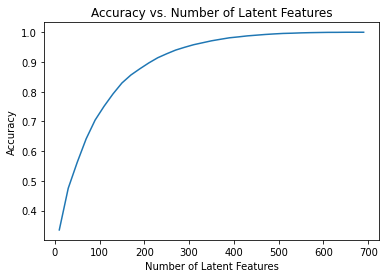

In [122]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [123]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create the matrix
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # For test
    test_idx = df_test.user_id.unique()
    test_arts = df_test.article_id.unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [124]:
# Get the number of ids in train df
train_idx = user_item_train.index
train_arts = user_item_train.columns

# User that we can make predictions
users_ok = np.intersect1d(test_idx,train_idx).size
# User that is not present in the train
users_nok = np.setdiff1d(test_idx, train_idx).size

# Articles in the test and train df
arts_ok = np.intersect1d(test_arts,train_arts).size
# Articles that is not present in the train
arts_nok = np.setdiff1d(test_arts, train_arts).size

print(f'{users_ok} users possible to make predictions')
print(f'{users_nok} users are not possible to make predictions')
print(f'{arts_ok} articles possible to make predictions')
print(f'{arts_nok} articles are not possible to make predictions')



20 users possible to make predictions
662 users are not possible to make predictions
574 articles possible to make predictions
0 articles are not possible to make predictions


In [125]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c , 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [126]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train.to_numpy(), full_matrices=False) # fit svd similar to above then use the cells below

In [127]:
# Find the user and articles there is in the train df
# It is only possible to predict for these users
users_in_train = np.intersect1d(test_idx, user_item_train.index)
articles_in_train = np.intersect1d(test_arts, user_item_train.columns)

# Filtring the test df
user_item_test_ok = user_item_test.loc[users_in_train, articles_in_train]

In [128]:
# Functions to assist

def predict_iter(user_id, article_id, 
    user_item_train=user_item_train, u_train=u_train, s_train = s_train,
    vt_train=vt_train, latent_factors=714):
    '''
    Function to get the predicted value from train matrix
    Input
        user_id - (int) user id to make prediction
        article_id - (int) article id to make prediction
        user_item_train - (array) the user_item train matrix
        u_train - (array) U matrix from SVD on train
        s_train - (array) S matrix from SVD on train
        vt_train - (array) VT matrix from SVD on train
        latent_factors - (int) number of latent factors to use
    Output
        pred - (float) the predict value for the user and article ids

    Description
        First, find the relative position of user id and article id
        in the train matrix. With theses cordinate, make the dot
        product of U, S and VT matrix reduced to that positions.
    '''
    # Relative position of user id and artcile id in train
    users_train = user_item_train.index
    article_train = user_item_train.columns
    user_pos = np.where(users_train == user_id)[0][0]
    article_pos = np.where(article_train == article_id)[0][0]
    
    # Reduce the U, S and VT matrix considering the positons and 
    # latent factors
    s_train_ = np.diag(s_train[:latent_factors]) # make it diagonal
    u_train_ = u_train[user_pos,:latent_factors]
    vt_train_ = vt_train[:latent_factors,article_pos]
    
    # Dot product return the predict value
    pred = np.dot(np.dot(u_train_, s_train_), vt_train_)

    return pred

def calculate_error_train(latent_factors=714):
    '''
    Funtion to retunr the RMSE for prediction using SVD on training set
    Input
        latent_factors - (int) number of latent_factors to use
    Output
        rmse - (float) the RMSE calculated for the latent_factors 
    '''
    # Slicing the matrices
    s_train_ = np.diag(s_train[:latent_factors])
    u_train_ = u_train[:,:latent_factors]
    vt_train_ = vt_train[:latent_factors,:]
    # Predictions
    pred_matrix_train = np.dot(np.dot(u_train_, s_train_), vt_train_)
    # Diffrences
    diffs = np.subtract(user_item_train, pred_matrix_train)
    # Error calculattion
    error_train = np.sum(np.sum(diffs**2))
    rmse = np.sqrt(error_train/user_item_train.size)
    
    return rmse 

In [129]:
# First, last see the errors using all latent factors

sse = 0
n_total = user_item_test_ok.size

# Iterate over user and article in the test matrix (only possible one)
for user in user_item_test_ok.index:
    for article in user_item_test_ok.columns:
        # Get the real value
        real = user_item_test_ok.loc[user,article]
        # Using predict function
        pred = predict_iter(user, article)
        # Get the error of prediction
        error = real - pred
        # Acumulate the error
        sse += error**2

# Calculate the RMSE 
rmse = np.sqrt(sse/n_total).round(2)

print(f'Using all latent factors we have:') 
print(f'Standard Squared Error: {sse.round(2)}')
print(f'Root mean square error: {rmse}')
    

Using all latent factors we have:
Standard Squared Error: 408.0
Root mean square error: 0.19


This SSE and RMSE is for situation using all factors from the training set.  

That means it is using the all information inside the training set to make predictions. It could represent a overfitting for training dataset, disturbing the predictions in test set.  

In the next cell I will make anaylis of the number of latent factors in prediction for both tests to observe what happens when the number of latent factors increase

In [130]:
# Testing different numbers of latent factors

# Range to iterate 10 to 710
latent_factors_list = np.arange(10,714,20)

# Initiate empty dict to alocate results
rmse_test_dict = {}
rmse_train_dict = {}


print('Number of Latent Factors | RMSE test | RMSE train')
for n_latent_factor in latent_factors_list:
    sse = 0
    cnt = 0
    for user in user_item_test_ok.index:
        for article in user_item_test_ok.columns:
            real = user_item_test_ok.loc[user,article]
            pred = predict_iter(user, article, latent_factors=n_latent_factor)
            cnt += 1 
            error = real - pred
            sse += error**2
    
    # RMSE for testing set
    rmse_test = np.sqrt(sse/cnt)
    # Insert into dict
    rmse_test_dict[n_latent_factor] = rmse_test
    # RMSE for training set
    rmse_train = calculate_error_train(n_latent_factor)
    # Insert into dict
    rmse_train_dict[n_latent_factor] = rmse_train

    # Printing the iterations
    # print(f'{k} | {rmse_test:.2f} | {rmse_train:.2f}')
    print(f'\t\t\t{n_latent_factor} \t\t  |   {rmse_test:.4f}     | \t  {rmse_train:.4f}')


Number of Latent Factors | RMSE test | RMSE train
			10 		  |   0.1446     | 	  0.0855
			30 		  |   0.1503     | 	  0.0770
			50 		  |   0.1546     | 	  0.0701
			70 		  |   0.1589     | 	  0.0644
			90 		  |   0.1621     | 	  0.0594
			110 		  |   0.1648     | 	  0.0549
			130 		  |   0.1685     | 	  0.0509
			150 		  |   0.1713     | 	  0.0472
			170 		  |   0.1734     | 	  0.0438
			190 		  |   0.1757     | 	  0.0407
			210 		  |   0.1778     | 	  0.0378
			230 		  |   0.1793     | 	  0.0351
			250 		  |   0.1806     | 	  0.0326
			270 		  |   0.1817     | 	  0.0302
			290 		  |   0.1827     | 	  0.0280
			310 		  |   0.1837     | 	  0.0259
			330 		  |   0.1846     | 	  0.0238
			350 		  |   0.1854     | 	  0.0219
			370 		  |   0.1862     | 	  0.0201
			390 		  |   0.1869     | 	  0.0184
			410 		  |   0.1874     | 	  0.0167
			430 		  |   0.1877     | 	  0.0151
			450 		  |   0.1879     | 	  0.0136
			470 		  |   0.1881     | 	  0.0122
			490 		  |   0.1882     | 	  0.0109
			51

With increase of latent factors, the error increases for testing data whereas decrease for training data.  

The graph bellow shows this behavoir

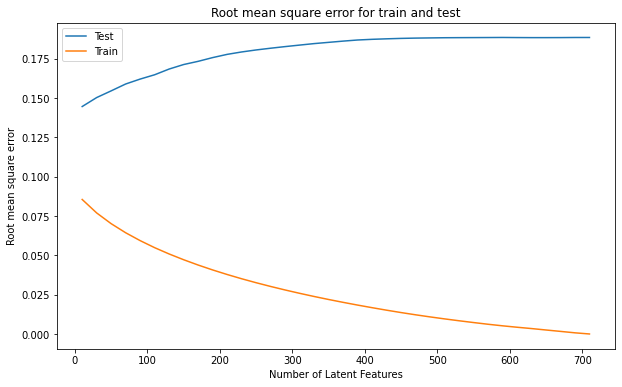

In [131]:
# Ploting results

# Values collected
rmse_test_values = rmse_test_dict.values()
rmse_train_values = rmse_train_dict.values()
latent_factors_number = rmse_test_dict.keys()

plt.figure(figsize=(10,6))
plt.plot(latent_factors_number, rmse_test_values, label='Test' )
plt.plot(latent_factors_number, rmse_train_values, label='Train')
plt.xlabel('Number of Latent Features')
plt.ylabel('Root mean square error')
plt.title('Root mean square error for train and test')
plt.legend()
plt.show()

This shows that, as the number of latent factors increases, there is a greater overfitting for the training data, impairing the prediction for the test.   

Thus, the ideal is to use a smaller number of factors, so that it fits in both situations. From the graph, the ideal value would be close to 150, the point at which the error for training begins to fall, going to overfitting and the error for the test is acceptable.  

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Using the machine learning training/testing method, it was possible to observe the performance of the recommendation engine offline and thus gain an idea of how the recommendations made would fit into a possible application in real life.  

Thanks to this, the risk of using too many latent factors when using SVD was observed. Overfitting training data can be a risk when implementing the recommendation engine, not being able to predict the real value in real data.  

However, to really prove the efficiency of the recommendation engine, the ideal would be to apply an A/B test in the real environment. By separating two groups in the experiment, one could observe how a metric of interest, for example, iteration rate per user, would vary with the implementation of the recommendation engine. Only then could the real gain and impact of the algorithm be measured.  